/vol/ideadata/ed52egek/conda/latentprivacy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/vol/ideadata/ed52egek/conda/latentprivacy/lib/python3.9/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


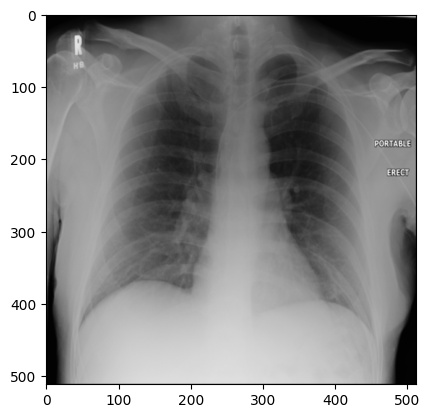

In [2]:
import torch 
from diffusers import AutoencoderKL
class VAE: 
    def __init__(self) -> None:
        vae = AutoencoderKL.from_pretrained(
            "stabilityai/stable-diffusion-2-base", subfolder="vae",
        )

        vae = vae.to("cuda")
        self.vae = vae

    def __call__(self, x):
        # assumes 0-1 normalized image
        single_image = False
        if len(x.size()) == 3: 
            single_image = True
            x = x.unsqueeze(dim=0)
        
        if x.min() >= 0: 
            x = x * 2 - 1 

        with torch.no_grad():
            encode = self.vae.encode(x.cuda())
            batch = encode.latent_dist.sample()[0] *  self.vae.config.scaling_factor
        if single_image: 
            batch = batch.squeeze(dim=0)
        return batch

    def encode(self, x): 
        return self(x)
    
    def decode(self, z): 
        """
        returns: decode image"""
        if len(z.size()) == 3: 
            z = z.unsqueeze(dim=0)
        with torch.no_grad():
            x = self.vae.decode(z / self.vae.config.scaling_factor, return_dict=False)[0]
            #x = self.vae.decode(z , return_dict=False)[0]

        x = ((1 + x) * 0.5).clip(0, 1)
        return x

from PIL import Image
from torchvision import transforms
from einops import repeat
def repeat_channels(x):
    if len(x.size()) == 3 and x.size()[0] == 1: 
        x = repeat(x, "1 h w -> 3 h w")
    if len(x.size()) == 4 and x.size()[1] == 1:
        x = repeat(x, "b 1 h w -> b 3 h w")
    return x

tf = transforms.Compose([transforms.ToTensor(), transforms.Resize(512), transforms.CenterCrop(512), repeat_channels])
image = tf(Image.open("/vol/ideadata/ed52egek/data/chestxray14/images/00003175_002.png"))
import matplotlib.pyplot as plt
plt.imshow(image.transpose(0,2).transpose(1,0))


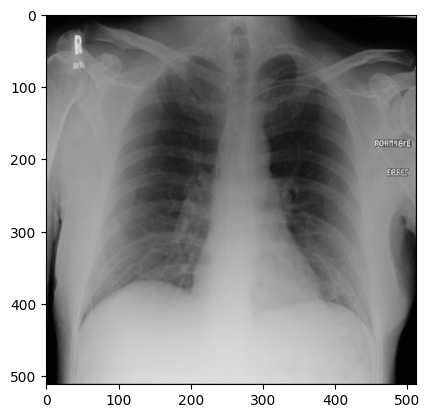

In [3]:
vae = VAE()
plt.imshow(vae.decode(vae.encode(image)).cpu().squeeze().transpose(0, 2).transpose(0,1))

In [4]:
vae.encode(image).min()

tensor(-10.7791, device='cuda:0')

In [5]:
image.size()

torch.Size([3, 512, 512])

In [6]:
image.shape

torch.Size([3, 512, 512])

In [7]:
import pandas as pd 

df = pd.read_csv("/vol/ideadata/ed52egek/data/chestxray14/Data_Entry_2017_v2020.csv")

file_path = '/vol/ideadata/ed52egek/data/chestxray14/test_list.txt'
test_images = []

with open(file_path, 'r') as file:
    for line in file:
        test_images.append(line.rstrip('\n').split(" ")[0])

#df["Image Index"].apply(lambda x: "test" if x in test_images else "train")
df["split"] = df["Image Index"].apply(lambda x: "test" if x in test_images else "train")
df["Image Index"] = df["Image Index"].apply(lambda x: "images/" + x)
df = df.rename(columns={"Finding Labels": "class", "Image Index": "path"}).reset_index(drop=True)
df = df.drop_duplicates(subset=['Patient ID'])
df

,path,class,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],split
0,images/00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,train
3,images/00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,train
4,images/00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,test
12,images/00000004_000.png,Mass|Nodule,0,4,82,M,AP,2500,2048,0.168,0.168,train
13,images/00000005_000.png,No Finding,0,5,69,F,PA,2048,2500,0.168,0.168,train
...,...,...,...,...,...,...,...,...,...,...,...,...
112114,images/00030801_000.png,No Finding,0,30801,38,M,PA,2500,2048,0.168,0.168,train
112116,images/00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168,test
112117,images/00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,test
112118,images/00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168,test


In [8]:
df.to_csv("/vol/ideadata/ed52egek/data/chestxray14/cxr14privacy.csv")

In [21]:
import pandas as pd
pd.read_csv("/vol/ideadata/ed52egek/data/chestxray14/cxr14privacy.csv")["split"].value_counts()

split
train    28008
test      2797
Name: count, dtype: int64

In [11]:
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
# Initialize the model
num_down_blocks = 6
block_out_channels = list((128, 128, 256, 256, 512, 512))
block_out_channels = tuple(block_out_channels[:num_down_blocks])

down_block_types = tuple(list((
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ))[-num_down_blocks:])

up_block_types = tuple([{"DownBlock2D": "UpBlock2D", "AttnDownBlock2D": "AttnUpBlock2D"}[x] for x in reversed(down_block_types)])

model = UNet2DModel(
    sample_size=64,
    in_channels=4,
    out_channels=4,
    layers_per_block=2,
    block_out_channels=block_out_channels,
    down_block_types=down_block_types,
    up_block_types=up_block_types,
)


/vol/ideadata/ed52egek/conda/latentprivacy/lib/python3.9/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [56]:

import torchxrayvision as xrv
import skimage, torch, torchvision

# Prepare the image:
img = skimage.io.imread("/vol/ideadata/ed52egek/data/chestxray14/images_001/images/00000001_000.png")
img = xrv.datasets.normalize(img, 255) # convert 8-bit image to [-1024, 1024] range
img = img[None, ...]
#img = img.mean(2)[None, ...] # Make single color channel

transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])

img = transform(img)
img = torch.from_numpy(img)

print(img.min())
print(img.size())
# Load model and process image
model = xrv.models.DenseNet(weights="densenet121-res224-all")
outputs = model(img[None,...]) # or model.features(img[None,...]) 
outputs

tensor(-1024.)
torch.Size([1, 224, 224])


tensor([[0.5055, 0.3079, 0.5230, 0.3161, 0.1913, 0.5032, 0.5417, 0.3932, 0.1469,
         0.5107, 0.6093, 0.5089, 0.4264, 0.0135, 0.2072, 0.2885, 0.3929, 0.4345]],
       grad_fn=<IndexPutBackward0>)

In [102]:
from typing import List
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from torchxrayvision.models import model_urls, _Transition, _DenseBlock, op_norm, get_weights
import torchxrayvision as xrv


class DenseNet(nn.Module):
    """Based on 
    `"Densely Connected Convolutional Networks" <https://arxiv.org/abs/1608.06993>`_
    and
    <https://github.com/mlmed/torchxrayvision/blob/master/torchxrayvision/models.py>

    Possible weights for this class include:

    .. code-block:: python

        ## 224x224 models
        model = xrv.models.DenseNet(weights="densenet121-res224-all")
        model = xrv.models.DenseNet(weights="densenet121-res224-rsna") # RSNA Pneumonia Challenge
        model = xrv.models.DenseNet(weights="densenet121-res224-nih") # NIH chest X-ray8
        model = xrv.models.DenseNet(weights="densenet121-res224-pc") # PadChest (University of Alicante)
        model = xrv.models.DenseNet(weights="densenet121-res224-chex") # CheXpert (Stanford)
        model = xrv.models.DenseNet(weights="densenet121-res224-mimic_nb") # MIMIC-CXR (MIT)
        model = xrv.models.DenseNet(weights="densenet121-res224-mimic_ch") # MIMIC-CXR (MIT)

    :param weights: Specify a weight name to load pre-trained weights
    :param op_threshs: Specify a weight name to load pre-trained weights 
    :param apply_sigmoid: Apply a sigmoid 

    """
    targets: List[str] = [
        'Atelectasis',
        'Consolidation',
        'Infiltration',
        'Pneumothorax',
        'Edema',
        'Emphysema',
        'Fibrosis',
        'Effusion',
        'Pneumonia',
        'Pleural_Thickening',
        'Cardiomegaly',
        'Nodule',
        'Mass',
        'Hernia',
        'Lung Lesion',
        'Fracture',
        'Lung Opacity',
        'Enlarged Cardiomediastinum',
    ]
    """"""

    def __init__(self,
                 growth_rate=32,
                 block_config=(6, 12, 24, 16),
                 num_init_features=64,
                 bn_size=4,
                 drop_rate=0,
                 num_classes=18,
                 in_channels=1,
                 weights=None,
                 op_threshs=None,
                 apply_sigmoid=False
                 ):

        super(DenseNet, self).__init__()

        self.apply_sigmoid = apply_sigmoid
        self.weights = weights
        
        self.transforms = torchvision.transforms.Compose([
            lambda x: (x * 1024), 
            #torchvision.transforms.Resize(224, torchvision.transforms.InterpolationMode.BILINEAR),
            #torchvision.transforms.CenterCrop(224),
            xrv.datasets.XRayCenterCrop(),
            xrv.datasets.XRayResizer(512),
            lambda x: x.clip(-1024, 1024),
            torchvision.transforms.ToTensor(),
        ])

        if self.weights is not None:
            if not self.weights in model_urls.keys():
                possible_weights = [k for k in model_urls.keys() if k.startswith("densenet")]
                raise Exception("Weights value must be in {}".format(possible_weights))

            # set to be what this model is trained to predict
            self.targets = model_urls[weights]["labels"]
            self.pathologies = self.targets  # keep to be backward compatible

            # if different from default number of classes
            if num_classes != 18:
                raise ValueError("num_classes and weights cannot both be specified. The weights loaded will define the own number of output classes.")

            num_classes = len(self.pathologies)

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(in_channels, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.num_features = num_features
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

        # needs to be register_buffer here so it will go to cuda/cpu easily
        self.register_buffer('op_threshs', op_threshs)

        if self.weights != None:
            self.weights_filename_local = get_weights(weights)

            try:
                savedmodel = torch.load(self.weights_filename_local, map_location='cpu')
                # patch to load old models https://github.com/pytorch/pytorch/issues/42242
                for mod in savedmodel.modules():
                    if not hasattr(mod, "_non_persistent_buffers_set"):
                        mod._non_persistent_buffers_set = set()

                self.load_state_dict(savedmodel.state_dict())
            except Exception as e:
                print("Loading failure. Check weights file:", self.weights_filename_local)
                raise e

            self.eval()

            if "op_threshs" in model_urls[weights]:
                self.op_threshs = torch.tensor(model_urls[weights]["op_threshs"])

            self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)

    def __repr__(self):
        if self.weights is not None:
            return "XRV-DenseNet121-{}".format(self.weights)
        else:
            return "XRV-DenseNet"

    def features2(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        return out

    def af_classification_mode(self):
        for param in self.features2.parameters():
            param.requires_grad = False
        self.classifier = nn.Linear(self.num_features, 1)

    def forward(self, x):
        # assumes -1 to 1, torch tensor of shape B x 3 x H x W 
        x = x.mean(axis=1, keepdim=False)
        x = x.numpy()
        x = self.transforms(x).transpose(0,1).transpose(1,2).unsqueeze(dim=0)
        print(x.size())
        print(x.min())
        print(x.max())

        # feature extraction 
        features = self.features2(x)

        # classification 
        out = self.classifier(features)

        if hasattr(self, 'apply_sigmoid') and self.apply_sigmoid:
            out = torch.sigmoid(out)

        if hasattr(self, "op_threshs") and (self.op_threshs != None):
            out = torch.sigmoid(out)
            out = op_norm(out, self.op_threshs)
        return out

model = DenseNet(weights="densenet121-res224-all")
#model = xrv.models.ResNet(weights="resnet50-res512-all")

In [103]:
img = skimage.io.imread("/vol/ideadata/ed52egek/data/chestxray14/images_001/images/00000001_000.png")
img = img / 127.5 - 1 
img = img[None,None,...]
img = torch.Tensor(img)
from einops import repeat
img = repeat(img, "b 1 h w -> b 3 h w")

out = model(img)
out


torch.Size([1, 1, 512, 512])
tensor(-1024.)
tensor(1012.1105)


tensor([[0.5302, 0.5200, 0.4425, 0.4964, 0.0804, 0.5014, 0.5113, 0.5194, 0.5018,
         0.5246, 0.3204, 0.5129, 0.5639, 0.1468, 0.0691, 0.5021, 0.5913, 0.5180]],
       grad_fn=<IndexPutBackward0>)

In [17]:
from typing import List
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage, torch, torchvision
from collections import OrderedDict
from torchxrayvision.models import model_urls, _Transition, _DenseBlock, op_norm, get_weights
import torchxrayvision as xrv

class ResNet(nn.Module):
    def __init__(self, weights: str = None, apply_sigmoid: bool = False):
        super(ResNet, self).__init__()

        self.weights = weights
        self.apply_sigmoid = apply_sigmoid

        if not self.weights in model_urls.keys():
            possible_weights = [k for k in model_urls.keys() if k.startswith("resnet")]
            raise Exception("Weights value must be in {}".format(possible_weights))

        self.weights_filename_local = get_weights(weights)
        self.weights_dict = model_urls[weights]
        self.targets = model_urls[weights]["labels"]
        self.pathologies = self.targets  # keep to be backward compatible

        if self.weights.startswith("resnet101"):
            self.model = torchvision.models.resnet101(num_classes=len(self.weights_dict["labels"]), pretrained=False)
            # patch for single channel
            self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        elif self.weights.startswith("resnet50"):
            self.model = torchvision.models.resnet50(num_classes=len(self.weights_dict["labels"]), pretrained=False)
            # patch for single channel
            self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        try:
            self.model.load_state_dict(torch.load(self.weights_filename_local))
        except Exception as e:
            print("Loading failure. Check weights file:", self.weights_filename_local)
            raise e

        if "op_threshs" in model_urls[weights]:
            self.register_buffer('op_threshs', torch.tensor(model_urls[weights]["op_threshs"]))

        self.upsample = nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)

        self.eval()

    def __repr__(self):
        if self.weights is not None:
            return "XRV-ResNet-{}".format(self.weights)
        else:
            return "XRV-ResNet"

    def save_model(self, path): 
        torch.save(self.model.state_dict(), path)

    def load_model(self, path): 
        self.model.load_state_dict(torch.load(path))

    def features(self, x):
        x = fix_resolution(x, 512, self)
        warn_normalization(x)

        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)

        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        #x = fix_resolution(x, 512, self)
        #warn_normalization(x)
        x = x.mean(dim=1, keepdims=True)

        out = self.model(x)

        #if hasattr(self, 'apply_sigmoid') and self.apply_sigmoid:
        #    out = torch.sigmoid(out)

        #if hasattr(self, "op_threshs") and (self.op_threshs != None):
        #    out = torch.sigmoid(out)
        #    out = op_norm(out, self.op_threshs)
        return out


model = ResNet(weights="resnet50-res512-all")

img = skimage.io.imread("/vol/ideadata/ed52egek/data/chestxray14/images_001/images/00000001_000.png")
img = img / 127.5 - 1 
img = img[None,None,...]
img = torchvision.transforms.Resize(512)(torch.Tensor(img))
from einops import repeat
img = repeat(img, "b 1 h w -> b 3 h w")

print(img.size())
out = model(img)
out

torch.Size([1, 3, 512, 512])


tensor([[-0.0224]], grad_fn=<AddmmBackward0>)

In [18]:
model.save_model("./model.pt")


In [19]:

model = ResNet(weights="resnet50-res512-all") # load initial model to set up resnet 
model.load_model("./model.pt")